In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, bs4

%matplotlib inline

# Обучение на размеченных данных 

## Подготовка данных 

Итак мы собрали порядка 23к размеченных отзывов о мобильных телефонах. Будем работать с данными в следующих форматах:

    - Необработанные тексты со всеми знаками препинания
    - Тексты, разбитые на массивы слов без знаков препинания
    - Тексты, разбитые на массивы слов без знаком препинания и с лемматизацией (с помощью библиотеки pymorphy2)
    
В данных label, равный 1, означает позитивный отзыв, 0 - негативный.
    
Для начала проверим сбалансированноть данных

In [3]:
raw_data = pd.read_csv("train_split.csv")

In [4]:
raw_data.head()

text  label  \
0  программное обеспечение iOS 13 работает с ошиб...      0   
1  Выпуск смартфона с недоработанной операционной...      1   
2  IPS экран, для меня лучше чем Amoled, отличная...      1   
3  Немного великоват для меня, хотя это дело прив...      0   
4  Быстрый ,хорошо держит батарею ,шикарно фотогр...      1   

                                         parsed_text  
0  ['программное', 'обеспечение', 'iOS', '13', 'р...  
1  ['Выпуск', 'смартфона', 'с', 'недоработанной',...  
2  ['IPS', 'экран', 'для', 'меня', 'лучше', 'чем'...  
3  ['Немного', 'великоват', 'для', 'меня', 'хотя'...  
4  ['Быстрый', 'хорошо', 'держит', 'батарею', 'ши...

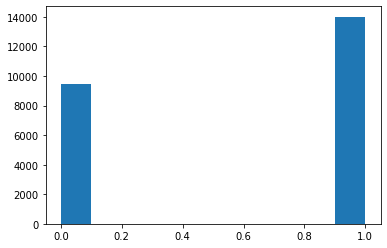

In [5]:
plt.hist(raw_data['label']);

Видно, что позитивных отзывов больше. Посмотрим на сколько больше и можно ли просто удалить часть.

In [6]:
pos = raw_data[raw_data['label'] == 1].shape[0]
neg = raw_data[raw_data['label'] == 0].shape[0]
diff = pos - neg
print(f'Позитивных отзывов - {pos}, негативных - {neg}, разница - {diff}')

Позитивных отзывов - 14009, негативных - 9426, разница - 4583


Негативных отзывов достаточно много, попробуем убрать часть позитивных.

In [7]:
# перемешиваем данные
shuffled_data = raw_data.sample(frac=1,random_state=4)

In [8]:
# все данные с негативными отзывами отложим в отдельный датафрейм
fraud_data = shuffled_data.loc[shuffled_data['label'] == 0]

In [9]:
# рандомно возьмем данные из преобладающего класса, нужно столько же экземпляров, сколько и в негативном классе
non_fraud_data = shuffled_data.loc[shuffled_data['label'] == 1].sample(n=neg, random_state=42, replace=True, axis = 0)

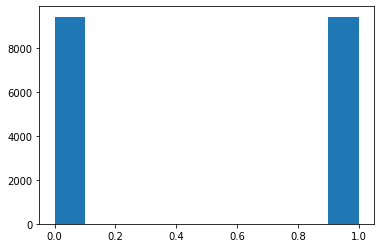

In [10]:
# соединим получившиеся данные
balanced_data = pd.concat([fraud_data, non_fraud_data])

plt.hist(balanced_data['label']);

In [11]:
pos = balanced_data[balanced_data['label'] == 1].shape[0]
neg = balanced_data[balanced_data['label'] == 0].shape[0]
balanced_diff = pos - neg
print(f'Позитивных отзывов - {pos}, негативных - {neg}, разница - {balanced_diff}')

Позитивных отзывов - 9426, негативных - 9426, разница - 0


Получилось достаточно мало данных. На всякий случай сделаем oversampling.

In [12]:
# все данные с позитивными отзывами отложим в отдельный датафрейм
fraud_data = shuffled_data.loc[shuffled_data['label'] == 1]

In [13]:
# рандомно возьмем данные из негативного класса, нужно столько же экземпляров, сколько не хватает в негативном классе до позитивного
non_fraud_data = shuffled_data.loc[shuffled_data['label'] == 0].sample(n=diff, random_state=10, replace=True, axis = 0)

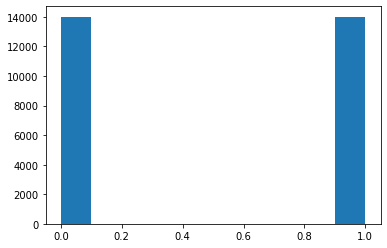

In [14]:
# соединим получившиеся данные
overbalanced_data = pd.concat([fraud_data, non_fraud_data, shuffled_data.loc[shuffled_data['label'] == 0]])

plt.hist(overbalanced_data['label']);

In [15]:
pos = overbalanced_data[overbalanced_data['label'] == 1].shape[0]
neg = overbalanced_data[overbalanced_data['label'] == 0].shape[0]
overbalanced_diff = pos - neg
print(f'Позитивных отзывов - {pos}, негативных - {neg}, разница - {overbalanced_diff}')

Позитивных отзывов - 14009, негативных - 14009, разница - 0


Теперь то же самое сделаем на данных, которые были нормализованы с помощью лемматизации

In [15]:
lemm_data = pd.read_csv("train_lemm.csv")

In [16]:
pos = lemm_data[lemm_data['label'] == 1].shape[0]
neg = lemm_data[lemm_data['label'] == 0].shape[0]
diff = pos - neg
shuffled_data = lemm_data.sample(frac=1,random_state=4)
fraud_data = shuffled_data.loc[shuffled_data['label'] == 0]
non_fraud_data = shuffled_data.loc[shuffled_data['label'] == 1].sample(n=neg, random_state=42, replace=True, axis = 0)
lemm_balanced_data = pd.concat([fraud_data, non_fraud_data])

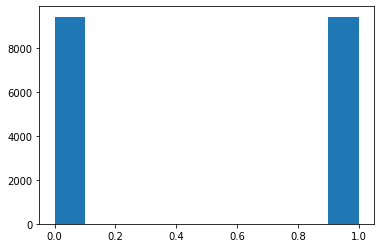

In [17]:
plt.hist(lemm_balanced_data['label']);

In [18]:
fraud_data = shuffled_data.loc[shuffled_data['label'] == 1]
non_fraud_data = shuffled_data.loc[shuffled_data['label'] == 0].sample(n=diff, random_state=10, replace=True, axis = 0)
lemm_overbalanced_data = pd.concat([fraud_data, non_fraud_data, shuffled_data.loc[shuffled_data['label'] == 0]])

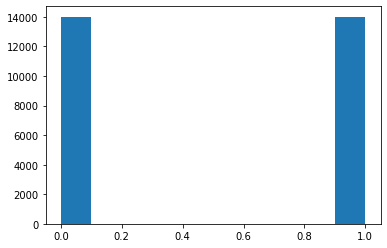

In [19]:
plt.hist(lemm_overbalanced_data['label']);

In [20]:
lemm_overbalanced_data.head()

text  label  \
16609  <p>Стильный и мощный аппарат\r\n</p>В предыдущ...      1   
13350  <p>Нет лучшего телефона в данной ценовой катег...      1   
3116   Компактность, дизайн, достойное время работы д...      1   
15317  Отличный яркий экран,изображения очень чёткие,...      1   
15124  Очень рад данной покупке. Выбирал между ним и ...      1   

                                               lemm_text  
16609  ['p', 'стильный', 'и', 'мощный', 'аппарат', 'p...  
13350  ['p', 'нет', 'хороший', 'телефон', 'в', 'дать'...  
3116   ['компактность', 'дизайн', 'достойный', 'время...  
15317  ['отличный', 'яркий', 'экран', 'изображение', ...  
15124  ['очень', 'рад', 'дать', 'покупка', 'выбирать'...

## Тренировка модели 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sys

In [22]:
X_train = overbalanced_data.parsed_text.values
y_train = overbalanced_data.label.values

Начнем с простого, логистическая регрессия

In [23]:
log_pipeline = Pipeline(
            [("vectorizer", CountVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [24]:
res_crossval = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='accuracy')

In [25]:
res_crossval.mean()

0.8877144178013129

In [26]:
log_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

Предскажем ответы

In [46]:
test_data = pd.read_excel('преобразованный файл Test.xlsx', encoding=sys.getfilesystemencoding())

In [47]:
X_test = []
temp_row = ''

for row in test_data.Column1.values:
    if row.find('<review>') != -1:
        temp_row = row.replace('<review>', '')
    elif row.find('</review>') != -1:
        X_test.append(temp_row + row.replace('</review>', ''))
    else:
        temp_row = temp_row + row    

In [29]:
res = log_pipeline.predict(X_test)

In [30]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('log_submission.csv', index=False)

Оценка на Kaggle - 0.78000

Та же логистическая регрессия, но с нормализованными данными

In [31]:
X_train = lemm_overbalanced_data.lemm_text.values
y_train = lemm_overbalanced_data.label.values

In [32]:
res_crossval = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='accuracy')

In [33]:
res_crossval.mean()

0.8762220593306609

In [34]:
log_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

Предскажем ответы

In [35]:
res = log_pipeline.predict(X_test)

In [36]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('lemm_log_submission.csv', index=False)

Оценка на Kaggle - 0.7

Попробуем еще на оригинальных данных

In [17]:
X_train = overbalanced_data.text.values
y_train = overbalanced_data.label.values

In [38]:
res_crossval = cross_val_score(log_pipeline, X_train, y_train, cv=5, scoring='accuracy')

In [39]:
res_crossval.mean()

0.8878571984545344

In [40]:
log_pipeline.fit(X_train, y_train);

Предскажем ответы

In [41]:
res = log_pipeline.predict(X_test)

In [42]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('original_log_submission.csv', index=False)

Оценка на Kaggle - 0.78

Уберем лемматизацию. Попробуем SVM.

In [43]:
from sklearn.linear_model import SGDClassifier

In [44]:
X_train = overbalanced_data.text.values
y_train = lemm_overbalanced_data.label.values

In [142]:
SGD_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer(ngram_range=(1,2))),
             ("classifier", SGDClassifier(random_state=42))])

In [116]:
param_grid = {'classifier__penalty': ['l1', 'l2'],
              'classifier__alpha': [0.01, 0.001, 0.0001],
              'classifier__max_iter': [100, 500, 1000]}

In [48]:
clf_SGD = GridSearchCV(SGD_pipeline, param_grid, n_jobs=-1)
clf_SGD = clf_SGD.fit(X_train, y_train)

In [51]:
clf_SGD.best_params_

{'classifier__alpha': 0.0001,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l2'}

In [49]:
res = clf_SGD.predict(X_test)

In [50]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('original_SVM_submission.csv', index=False)

Результат - 0.82

Байес

In [52]:
from sklearn.naive_bayes import BernoulliNB

In [53]:
bayes_pipeline = Pipeline(
             [("vectorizer", TfidfVectorizer(ngram_range=(1,2))),
             ("classifier", BernoulliNB())])

res_crossval = cross_val_score(bayes_pipeline, X_train, y_train, cv=5, scoring='accuracy')

In [54]:
res_crossval

array([0.83029979, 0.80817273, 0.7544611 , 0.77779761, 0.7587007 ])

In [55]:
bayes_pipeline.fit(X_train, y_train);

In [135]:
res = bayes_pipeline.predict(X_test)

In [136]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('bayes_submission.csv', index=False)

Результат - 0.8

Попробуем почистить X_train и X_test от лишних тегов и символов. Нас интересуют только слова на русском.

In [35]:
import re
import string

In [33]:
def clean_data(X_data):
    for i in np.arange(len(X_data)):
        X_data[i] = re.sub(r"[#%@*/<>A-Za-z0-9]", " ", X_data[i])
        X_data[i] = re.sub(r"\r\n|\r|\n", " ", X_data[i])
        X_data[i] = " ".join(X_data[i].split())

In [190]:
clean_data(X_train)
clean_data(X_test)

Найдем оптимальные параметры для векторайзера

In [130]:
param_grid = {'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'vectorizer__analyzer': ['word', 'char'],
              'vectorizer__min_df': [10, 20, 30]}

In [131]:
log_pipeline = Pipeline(
            [("vectorizer", CountVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [132]:
log_reg = GridSearchCV(log_pipeline, param_grid, n_jobs=-1)
log_reg = log_reg.fit(X_train, y_train)

In [133]:
print("Best score found by grid search:")
print(log_reg.best_score_)

Best score found by grid search:
0.8905337114829506


In [134]:
log_reg.best_params_

{'vectorizer__analyzer': 'char',
 'vectorizer__min_df': 10,
 'vectorizer__ngram_range': (1, 4)}

In [137]:
res = log_reg.best_estimator_.predict(X_test)

In [139]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('logreg_submission.csv', index=False)

Результат - 0.82

Попробуем деревья решений

In [148]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [146]:
param_grid = {'classifier__max_depth': [10, 50, 100],
              'classifier__n_estimators': [10, 20, 30, 40, 50]}

In [150]:
Tree_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer(analyzer = 'char', min_df = 10, ngram_range=(1,4))),
             ("classifier", RandomForestClassifier())])

In [151]:
clf_tree_count = GridSearchCV(Tree_pipeline, param_grid, n_jobs=-1)
clf_tree_count = clf_tree_count.fit(X_train, y_train)

In [152]:
print("Best score found by grid search:")
print(clf_tree_count.best_score_)

Best score found by grid search:
0.8812897406469947


In [157]:
res = clf_tree_count.best_estimator_.predict(X_test)

In [158]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('tree_submission.csv', index=False)

Результат - 0.68. Видно, что деревья сильно переобучаются.

Ансамбли. Возьмем для примера логистическую регрессию и Байеса

In [159]:
param_grid = {'voting': ['hard', 'soft']}

eclf1 = GridSearchCV(VotingClassifier(estimators=[('logreg', log_reg.best_estimator_), ('bayes', bayes_pipeline)]), param_grid, n_jobs=-1)
eclf1 = eclf1.fit(X_train, y_train)

In [160]:
print("Best score found by grid search:")
print(eclf1.best_score_)

Best score found by grid search:
0.8893205409103897


In [161]:
res = eclf1.best_estimator_.predict(X_test)

In [162]:
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('ensemble_submission.csv', index=False)

Результат - 0.74

Еще раз обработаем данные, заменим "ё" на "е" и приведем к нижнему регистру, уберем пунктуацию

In [37]:
from string import punctuation

In [51]:
def change_data(X_data):
    for i in np.arange(len(X_data)):
        X_data[i] = X_data[i].lower().replace("ё", "е")
        X_data[i] = ' '.join([c for c in X_data[i] if c not in punctuation])

In [191]:
change_data(X_train)
change_data(X_test)

In [186]:
param_grid = {'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'vectorizer__analyzer': ['word', 'char'],
              'vectorizer__min_df': [10, 20, 30]}

In [187]:
log_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [193]:
log_reg = GridSearchCV(log_pipeline, param_grid, n_jobs=-1)
log_reg = log_reg.fit(X_train, y_train)

In [194]:
print("Best score found by grid search:")
print(log_reg.best_score_)

Best score found by grid search:
0.8745092647547971


In [195]:
res = log_reg.best_estimator_.predict(X_test)
res_df = pd.DataFrame()
res_df['Id'] = np.arange(100)
res_df['y'] = ['pos' if x == 1 else 'neg' for x in res]
res_df.to_csv('logreg_submission.csv', index=False)

Результат - 0.84

# Выводы 

С логистической регрессией получаются более стабильные результаты. Также неплохо показал себя SVM. Попробовать другие методы и более развернутую сетку параметров не позволяют вычислительные ресурсы.

# Попытка довести результат до 0.86

In [48]:
X_train = overbalanced_data.text.values
y_train = overbalanced_data.label.values

In [49]:
clean_data(X_train)
clean_data(X_test)
change_data(X_train)
change_data(X_test)

In [39]:
param_grid = {'vectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'vectorizer__analyzer': ['word', 'char'],
              'vectorizer__min_df': [10, 20, 30]}

In [40]:
log_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
             ("classifier", LogisticRegression(solver="liblinear"))])

In [41]:
log_reg = GridSearchCV(log_pipeline, param_grid, n_jobs=-1)
log_reg = log_reg.fit(X_train, y_train)

In [52]:
print("Best score found by grid search:")
print(log_reg.best_score_)

Best score found by grid search:
0.8745092647547971


In [ ]:
res = log_reg.best_estimator_.predict(X_test)